<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW2/Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 2 Problem 4**

Here you will explore how to use (1) linear regression to model gene count relationships, and investigate the assumptions these models will make. Utilizing the metadata from single-cell datasets, you will also apply (2) partial correlations to remove the influence of possibly confounding variables from your calculations of correlation between genes and their expression profiles.

##**Import data and install packages**

In [3]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [4]:
# ! allows you to run commands in the command line, as you would in your normal terminal/command line interface

In [5]:
#Download count matrix of cell by gene counts
#Cells are 10x sequenced neurons from the mouse hypothalamus (Kim et al. 2019)

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/D1.2072','.gz')

/tmp/ipykernel_6456/2283168285.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/104912 [00:00<?, ?B/s]

'D1.2072.gz'

In [6]:
#Download csv of metadata for cells (cell type classification, sex of mouse)

download_file('10.22002/D1.8969','.gz')

/tmp/ipykernel_6456/2283168285.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/349 [00:00<?, ?B/s]

'D1.8969.gz'

In [7]:
#Download csv of metadata for genes (gene names)
download_file('10.22002/D1.2066','.gz')

/tmp/ipykernel_6456/2283168285.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/12 [00:00<?, ?B/s]

'D1.2066.gz'

In [8]:
#Gunzip the files we downloaded
!gunzip *.gz

In [9]:
!mv D1.2072 tenx.mtx
!mv D1.8969 tenx_obs.csv
!mv D1.2066 var.csv

## **Read in data for analysis**

**The dataset**

This dataset is taken from [Kim et al. 2019](https://www.sciencedirect.com/science/article/pii/S0092867419310712). The goal of this study was to discern the various neuronal cell types present in the mouse ventromedial hypothalamus (VMH), a region whose neurons control/influence social behaviors e.g. mounting and aggression. 

This dataset comprises neurons from *male and female* mice in different behavioral states, covering *30 distinct neuron populations or cell types*.

Here we are analyzing only the 10x sequenced samples.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0092867419310712-fx1_lrg.jpg" alt="AbstractFigure" width="500" height="500">




**The Count matrix**

This matrix is 41,580 cells by 1,999 genes. We will use the full dataset to fit these models.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes. 

3. The ~2000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').


 


In [10]:
#Get gene count matrix
count_mat = sio.mmread('tenx.mtx')
count_mat.shape

(41580, 1999)

In [11]:
#Get metadata dataframe for the 41,580 cells (rows of the matrix)
meta = pd.read_csv('tenx_obs.csv',index_col = 0)
meta.head()

,cell_barcode,sex_label,cell_type
0,4_AAACCTGAGCGCCTCA,F,Nr5a1_4
1,4_AAACCTGCACAGTCGC,F,Tsix_Esr1_1
2,4_AAACCTGCAGATTGCT,F,Dlk1_3
3,4_AAACCTGCATACTCTT,F,Tsix_Esr1_1
4,4_AAACCTGGTCCGTTAA,F,Scgn


In [12]:
#Get metadata dataframe for the 1,999 genes (columns of the matrix)

meta_gene = pd.read_csv('var.csv',index_col = 0)
meta_gene.head()


,gene_name
Gm1992,Gm1992
Lypla1,Lypla1
Npbwr1,Npbwr1
Sntg1,Sntg1
1700034P13Rik,1700034P13Rik


In [13]:
#Access the list in each column by meta['name_of_col']
cell_types = meta['cell_type']
cell_types[0:5]

0        Nr5a1_4
1    Tsix_Esr1_1
2         Dlk1_3
3    Tsix_Esr1_1
4           Scgn
Name: cell_type, dtype: object

In [14]:
#See all the cell type categories
np.unique(meta['cell_type']) #Cell populations are marked by the genes they express (as comparec to other cell populations)

array(['Dlk1_1', 'Dlk1_2', 'Dlk1_3', 'Dlk1_4', 'Dlk1_5', 'Dlk1_6',
       'Esr1_1', 'Esr1_2', 'Esr1_3', 'Esr1_4', 'Esr1_5', 'Esr1_6',
       'Nr5a1_1', 'Nr5a1_10', 'Nr5a1_2', 'Nr5a1_3', 'Nr5a1_4', 'Nr5a1_5',
       'Nr5a1_6', 'Nr5a1_7', 'Nr5a1_8', 'Nr5a1_9', 'Nr5a1_Foxp2_1',
       'Nr5a1_Foxp2_2', 'Nup62cl', 'Satb2_1', 'Satb2_2', 'Satb2_3',
       'Scgn', 'Tsix_Esr1_1'], dtype=object)

In [15]:
#Filter the count matrix for a particular cell type (across all genes)

#Remember! Cells are ROWS and Genes are COLUMNS

indices = meta['cell_type'].isin(['Tsix_Esr1_1']) #Get indices for where the cell_type is Tsix_Esr1_1 only

count_sub = count_mat[indices,:] #Filter rows (cells) of matrix
count_sub.shape

(1659, 1999)

In [16]:
count_sub

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        5.40639958],
       [0.        , 0.        , 0.        , ..., 0.        , 4.9682535 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
#The sexes
np.unique(meta['sex_label'])

array(['F', 'M'], dtype=object)

## **Problem 4 (28 points)**
Here we will explore how to use (1) linear regression to model gene count relationships, and investigate the assumptions these models will make.

Given the multiple categories of metadata we have for these cells, we will also utilize (2) partial correlations to remove the influence of possibly confounding variables from our calculations of correlation between genes and their expression profiles.

***Linear Regression***

How to use linear regression functions from sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html 
```
>>> import numpy as np
>>> from sklearn.linear_model import LinearRegression
>>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_
3.0...
```



### **a) Find x ~ y and y ~ x regression model coefficients for a pair of genes and plot x versus y in each case. ( 4 points)** 

By regressing y (gene 2) on x (gene 1) written as y ~ x, or vice versa, we are modeling how gene 2's expression changes as a function of gene 1. Specifically, the $\beta$ parameter from the fit $y = \alpha + \beta x$ represents the change in the value of dependent variable (y here) corresponding to unit change in the value of independent variable (x here). 

**Using the given gene pair (below), report the intercept and coefficient values for each of the two models.**

In [18]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [19]:
def get_gene(gene):
    indices = meta_gene['gene_name'].isin([gene]) #Get indices for where the cell_type is Tsix_Esr1_1 only
    count_sub = count_mat[:,indices] #Filter rows (cells) of matrix
    return count_sub



In [20]:
#Set genes
gene1 = 'Nr4a3' # Steroid-thyroid hormone-retinoid receptor
gene2 = 'Gm31363' # Non-coding RNA 

#Do regression x ~ y and y ~ x
x = get_gene(gene1)
y = get_gene(gene2)

regyx = LinearRegression().fit(x, y)
regxy = LinearRegression().fit(y, x)

#Print coefficients and intercepts
print("regression y~x coef: {} intercept: {}".format(regyx.coef_[0][0], regyx.intercept_[0]))
print("regression x~y coef: {} intercept: {}".format(regxy.coef_[0][0], regxy.intercept_[0]))


regression y~x coef: 0.44563656227709547 intercept: 0.14618994842969885
regression x~y coef: 0.42521328361434807 intercept: 0.13468847767526473


### **b) Calculate the $R^2$ and the Pearson correlation coefficient for the gene pair, given each regression model ( 4 points)** 

The  $R^2$ coefficient of determination is defined as 1 - (sum of squares of the residuals)/(sum of total squares). Here the numerator represents deviation from the model predictions, and the denominator represents the variance of the given dataset (observations). $R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_i (y_i - y_{pred})^2}{\sum_i (y_i - \bar{y})^2} $ (where $\bar{y}$ is the mean). This measures the proportion of the variation in y that is predictable from x.


Pearson correlation (Pearson's r) is defined as $\frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_i (x_i - \bar{x})^2\sum_i (y_i - \bar{y})^2}}$. This represents the covariance of two variables divided by the product of their standard deviations i.e. a normalized representation of covariance to measure the linear correlation between the variables.



**Report the $R^2$ for each model and the Pearson correlation calculations (you will only need to calculate one Pearson correlation value). Calculate these values directly using the formulas given. Additionally, print the 'score' for each regression model and check that this matches your $R^2$ calculation.**

In [21]:
def pearson(x, y):
    return sum((x - np.mean(x)) * (y - np.mean(y))) / np.sqrt(np.sum((x - np.mean(x))**2) * np.sum((y - np.mean(y))**2))

In [22]:
#Report values
ypredyx = regyx.predict(x)
ypredxy = regxy.predict(y)
r2yx = 1 - sum((y-ypredyx)**2)/sum((y-np.mean(y))**2)
r2xy = 1 - sum((x-ypredxy)**2)/sum((x-np.mean(x))**2)

print("R^2 y~x: {}   R^2 x~y: {}".format(r2yx, r2xy))

R^2 y~x: [0.18949059]   R^2 x~y: [0.18949059]


In [23]:
pearson_part1 = pearson(x, y)
print("Pearson correlation: {}".format(pearson_part1))

Pearson correlation: [0.43530516]


### **c) Show that if the data is mean-centered and scaled, then $r = \beta$ ($r$ is Pearson's r, and $\beta$ is the coefficient or slope of the model). ( 4 points)** 

The slope of the regression line (for y ~ x) can be written as $\beta = \frac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sum_i (x_i - \bar{x})^2}$ or equivalently $r\frac{\sigma_y}{\sigma_x}$ where $r$ is Pearson's r. $\sigma$ represents standard deviation. 

If x and y are standardized, $x_{std} = \frac{x - \bar{x}}{\sigma_x}$ and $y_{std} = \frac{y - \bar{y}}{\sigma_x}$, to have a 0 mean and a standard deviation of 1, the regression fit is $\hat{y} = \beta x$ ($\alpha = 0$) and $\beta = r$.

**Report the Pearson's r value and the $\beta$ coefficient for the two models after data standardization.**


In [31]:
xstd = (x - np.mean(x))/np.std(x)
ystd = (y - np.mean(y))/np.std(y)

regyxstd = LinearRegression().fit(xstd, ystd)
regxystd = LinearRegression().fit(ystd, xstd)

print("regression y~x coef: {} intercept: {}".format(regyxstd.coef_[0][0], regyxstd.intercept_[0]))
print("regression x~y coef: {} intercept: {}".format(regxystd.coef_[0][0], regxystd.intercept_[0]))

regression y~x coef: 0.4353051641601039 intercept: -1.1716757883248505e-16
regression x~y coef: 0.43530516416010023 intercept: 7.316436695936301e-17


In [35]:


pearsonstd = pearson(xstd, ystd)
print("Pearson correlation std: {}".format(pearsonstd))

Pearson correlation std: [0.43530516]


Thus, we see that pearson's correlation is the same as the beta for both models.

### **d) Plot model residuals to check homoscedascity assumption for the gene pair ( 4 points)**

OLS (ordinary least squares) assumes that the error term (“noise” in the relationship between the independent and the dependent variable) is the same across all values of the independent variable. If this is true for our dataset, we would expect a random distribution of residuals (deviations from the prediction) about the zero line.

**Plot the residuals (predicted - observed) values for each model. The plots will have the residuals on the y-axis versus the independent (input) variable values (x). Report if you think the homoscedascity assumption is met.**

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Text(0, 0.5, 'Residuals')

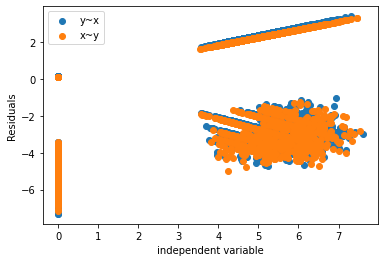

In [34]:
#Plot residuals for the predicted y's (for both models) and describe if you believe the assumption holds

plt.scatter(x, ypredyx - y, label="y~x")
plt.scatter(y, ypredxy - x, label="x~y")
plt.legend()
plt.xlabel("independent variable")
plt.ylabel("Residuals")


--- Your comments here ---

We see that the residuals aren't quite randomly distributed about 0. So the assumption does not hold here.

***Partial Correlations***

Partial correlation is a measure of association between two variables, after controlling for the effect of a third random variable. As a general example, one may want to measure correlation between age and memory performance, but may want to remove the effect of education level from this correlation.

Partial correlation can be framed as correlation of the residuals from two regression problems: (1) X ~ Z and (2) Y ~ Z. The partial correlation between X and Y is then the pearson correlation of the residuals of (1) and (2).

Below we will go through the steps of calculating the partial correlation for the gene pair in parts a-d.

### **e) Find linear regression fits of each gene's expression profile (for the gene pair in a-d) against the sex of cells. Report the coefficient and intercept for each model. ( 4 points)**

Fit linear regression models of (1) gene 1 expression against sex (binary 0 or 1 for Male or Female) and (2) gene 2 expression against sex (binary 0 or 1 for Male or Female). This is done across all cells (the count matrix with both sexes and all cell types). Convert the 'M' and 'F' to binary values, (0 or 1), for the regression models.


In [28]:
#Set up regression models
gene1_exp = get_gene(gene1)
gene2_exp = get_gene(gene2)
meta["sex_label_binary"] = (meta["sex_label"] == "F").astype(int)
sex = np.array(meta["sex_label_binary"]).reshape(-1, 1)

gene1_reg = LinearRegression().fit(sex, gene1_exp)
gene2_reg = LinearRegression().fit(sex, gene2_exp)

#Print coefficients and intercepts
print("Gene1 regression coefs: {}  intercept: {}".format(gene1_reg.coef_, gene1_reg.intercept_))
print("Gene2 regression coefs: {}  intercept: {}".format(gene2_reg.coef_, gene2_reg.intercept_))


Gene1 regression coefs: [[-0.1372853]]  intercept: [0.27129689]
Gene2 regression coefs: [[-0.14775738]]  intercept: [0.28501545]


### **f) Report the residuals from each regression fit ( 4 points)**
Residuals are defined as predicted - observed values, for each model.

**Report the first 5 residual values for each model.**

In [29]:
#Get residuals
gene1_resid = gene1_reg.predict(sex) - gene1_exp
gene2_resid = gene2_reg.predict(sex) - gene2_exp

print("gene1 residuals: {}\n gene2 residuals: {}".format(gene1_resid[:5], gene2_resid[:5]))


gene1 residuals: [[0.13401158]
 [0.13401158]
 [0.13401158]
 [0.13401158]
 [0.13401158]]
 gene2 residuals: [[0.13725807]
 [0.13725807]
 [0.13725807]
 [0.13725807]
 [0.13725807]]


### **g) Now find and report the partial correlation between the genes in pair. This is the Pearson correlation coefficient, as defined in b, between the residuals. ( 4 points)**

In [30]:
#Get correlation
pearson_resids = pearson(gene1_resid, gene2_resid)
print("pearson Correlation between residuals: {}".format(pearson_resids))

pearson Correlation between residuals: [0.43380708]
